## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve
from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "Figure3")

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

In [2]:
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,394512,10509415,NaN,39157213,2178-11-07 21:01:00,2178-11-07 21:26:00,45,M,2173,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,50,False,False,False,0 days 00:25:00,NaN,NaN,False,False,False,0,0,0,2178-11-09 10:37:00,1 days 13:11:00,True,0,0,0,0,0,0,0.42,NaN,1.55,36.722222,74.0,20.0,100.0,162.0,129.0,9.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.611111,72.0,16.0,100.0,180.0,123.0,0.0,3.0,9.0,140.000000,2,0,5,0,0,1
1,163920,19402485,27265022.0,35695207,2149-04-10 22:36:00,2149-04-11 00:47:05,55,M,2149,NaN,2149-04-11 00:46:00,2149-04-12 15:00:00,NaN,BLACK/AFRICAN AMERICAN,2149-04-10 22:36:00,2149-04-11 03:20:00,Other,2149,55,False,False,False,0 days 02:11:05,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,2.18,NaN,NaN,36.777778,90.0,20.0,97.0,131.0,77.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,68.0,18.0,100.0,128.0,68.0,0.0,2.0,6.0,95.000000,1,4,3,0,0,1
2,235492,12126972,21011915.0,33586273,2110-03-31 10:59:00,2110-03-31 15:33:00,65,F,2110,NaN,2110-03-31 14:50:00,2110-04-02 13:40:00,NaN,WHITE,2110-03-31 10:59:00,2110-03-31 15:33:00,Other,2110,65,False,False,False,0 days 04:34:00,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,4.57,NaN,NaN,36.833333,90.0,18.0,94.0,122.0,71.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.333333,84.0,22.0,93.0,138.0,80.0,4.0,4.0,3.0,88.000000,2,4,5,1,0,1
3,43991,17759885,NaN,31346320,2155-01-03 09:43:00,2155-01-03 09:54:00,63,F,2154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2155,64,False,False,False,0 days 00:11:00,NaN,NaN,False,False,False,0,1,1,2155-02-10 12:49:00,38 days 02:55:00,False,0,0,0,0,0,0,0.18,NaN,38.12,36.611111,98.0,14.0,99.0,136.0,71.0,2.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.222222,85.0,14.0,99.0,138.0,78.0,0.0,0.0,4.0,92.666667,2,4,3,1,1,0
4,291495,12197131,26028634.0,34998956,2123-07-30 11:41:00,2123-07-30 23:24:00,60,M,2123,NaN,2123-07-30 17:24:00,2123-08-08 13:02:00,NaN,OTHER,2123-07-30 11:41:00,2123-07-30 23:24:00,Medicaid,2123,60,False,False,False,0 days 11:43:00,NaN,NaN,False,True,False,0,0,0,2125-08-30 20:50:00,761 days 21:26:00,False,0,0,0,0,0,0,11.72,NaN,761.89,36.833333,82.0,16.0,100.0,125.0,85.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,75.0,17.0,100.0,144.0,80.0,0.0,7.0,8.0,98.333333,2,4,3,0,0,1


### 1. task-specific filter

In [4]:
print('Before filtering: training size =', len(df_train), ', testing size =', len(df_test))
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False].reset_index()
print('After filtering: training size =', len(df_train), ', testing size =', len(df_test))

Before filtering: training size = 353150 , testing size = 88287
After filtering: training size = 353149 , testing size = 88287


### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.06330787087916223 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/miniconda3/envs/mimic-ed/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 2.9343230724334717 seconds
AUC: 0.8632228580221659
AUPRC: 0.32032108467280795
Sensitivity: 0.7831607735885915
Specificity: 0.7861557329742208
Score thresold: 0.06416516335075427
2.5 97.5


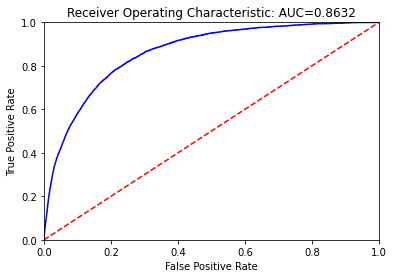

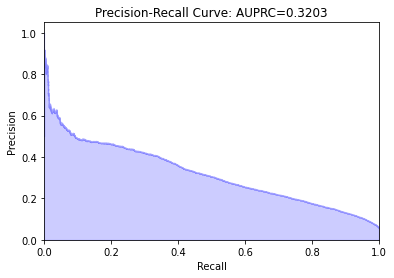

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task2_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 51.86137652397156 seconds
AUC: 0.874301081405677
AUPRC: 0.37677463281995405
Sensitivity: 0.8005469818323891
Specificity: 0.7919632550981146
Score thresold: 0.07333333333333333
2.5 97.5


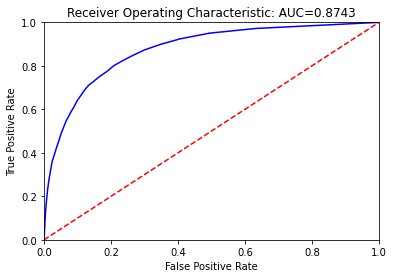

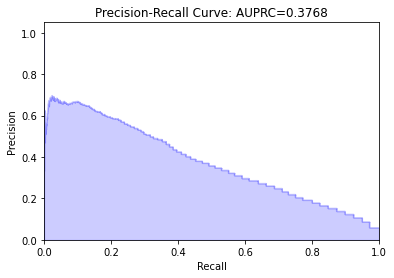

[0.09937619 0.01470996 0.00648803 0.01019234 0.01877402 0.00630944
 0.00999285 0.01697148 0.0031896  0.00673478 0.01203326 0.07604255
 0.09395805 0.05654235 0.0502606  0.10067915 0.08447894 0.04106852
 0.09029217 0.00582229 0.00632328 0.00397621 0.00148111 0.00215054
 0.00241584 0.00282257 0.00484673 0.00351245 0.00309675 0.00518476
 0.00567014 0.00491457 0.00511689 0.00292499 0.00729641 0.00267977
 0.00275536 0.00469053 0.00744623 0.00476362 0.00258922 0.00497072
 0.00553068 0.00301196 0.00377973 0.0011749  0.00714831 0.00473005
 0.00450665 0.00492925 0.0089207  0.00585242 0.005553   0.00182837
 0.00543035 0.00553102 0.00470837 0.0070113  0.00228766 0.00446019
 0.00480313 0.00376514 0.0026194  0.00687219]


In [12]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 60.55331468582153 seconds
AUC: 0.8797656805448562
AUPRC: 0.385149910782927
Sensitivity: 0.7989841765969916
Specificity: 0.7989130434782609
Score thresold: 0.06621406869702667
2.5 97.5


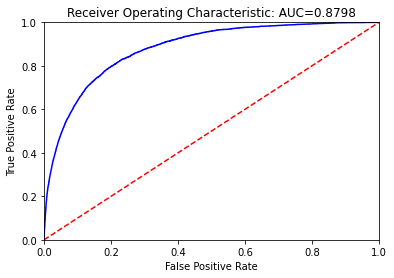

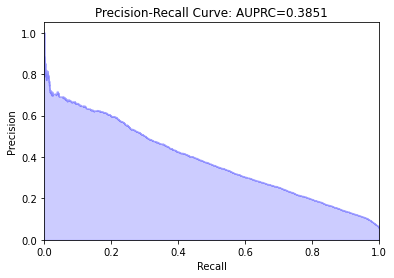

In [13]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [14]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [15]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp')

2022-08-31 14:09:08.061550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 14:09:08.913695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22290 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-08-31 14:09:08.914659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22306 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Epoch 1/20
  37/1766 [..............................] - ETA: 7s - loss: 0.6521 - accuracy: 0.9118 - auc: 0.5714 - auprc: 0.0882 - true_positives: 54.0000 - true_negatives: 6693.0000 - precision: 0.1622 - recall: 0.1262           

2022-08-31 14:09:10.786010: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1766/1766 [==============================] - 10s 5ms/step - loss: 0.1929 - accuracy: 0.9400 - auc: 0.8134 - auprc: 0.2625 - true_positives: 1951.0000 - true_negatives: 329999.0000 - precision: 0.4788 - recall: 0.0928
Epoch 2/20
1766/1766 [==============================] - 9s 5ms/step - loss: 0.1724 - accuracy: 0.9412 - auc: 0.8541 - auprc: 0.3209 - true_positives: 2901.0000 - true_negatives: 329485.0000 - precision: 0.5237 - recall: 0.1380
Epoch 3/20
1766/1766 [==============================] - 8s 5ms/step - loss: 0.1677 - accuracy: 0.9420 - auc: 0.8643 - auprc: 0.3417 - true_positives: 2968.0000 - true_negatives: 329706.0000 - precision: 0.5512 - recall: 0.1412
Epoch 4/20
1766/1766 [==============================] - 9s 5ms/step - loss: 0.1664 - accuracy: 0.9424 - auc: 0.8671 - auprc: 0.3462 - true_positives: 2904.0000 - true_negatives: 329915.0000 - precision: 0.5681 - recall: 0.1381
Epoch 5/20
1766/1766 [==============================] - 9s 5ms/step - loss: 0.1643 - accuracy: 0.9428 

MLP:
2759/2759 [==============================] - 3s 1ms/step
AUC: 0.880483051846244
AUPRC: 0.3748690760503032
Sensitivity: 0.8194959953115843
Specificity: 0.7871777606771835
Score thresold: 0.05180902
2.5 97.5


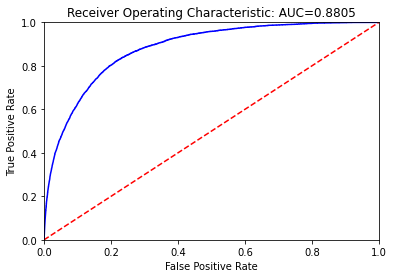

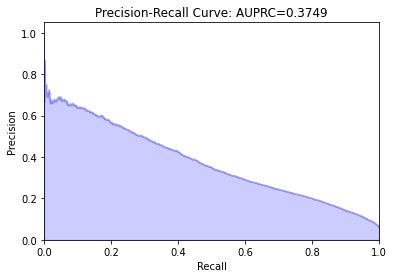

In [16]:
print("MLP:")
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [17]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.8038331092450618
AUPRC: 0.19386218845020076
Sensitivity: 0.8698964641531549
Specificity: 0.6400658907272028
Score thresold: -2.0
2.5 97.5


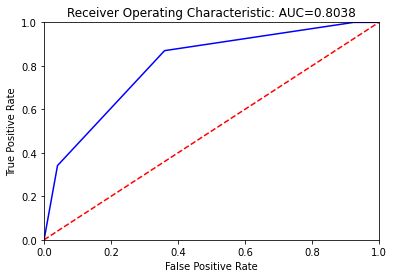

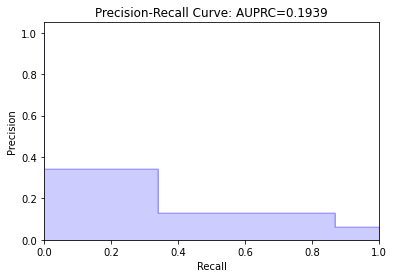

In [18]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI", random_seed=random_seed)

In [19]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_Crtical.csv')))
df_test["AutoScore"] = AutoScore_pred["pred_score"]

AutoScore
AUC: 0.8461127920967695
AUPRC: 0.27781732368930934
Sensitivity: 0.804453994920883
Specificity: 0.7279843208926511
Score thresold: 66
2.5 97.5


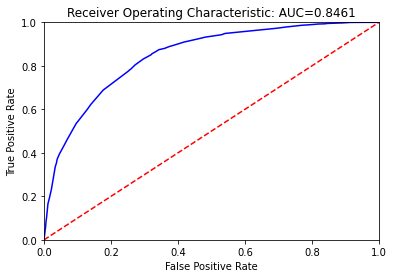

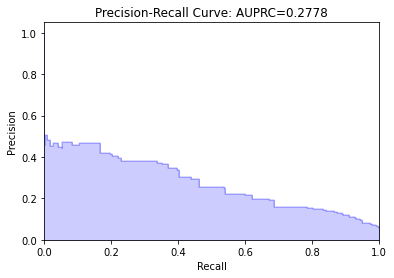

In [20]:
get_score_performance("AutoScore", random_seed=random_seed) 

score_NEWS
AUC: 0.6339973706113844
AUPRC: 0.1409964855787802
Sensitivity: 0.46356710294979486
Specificity: 0.7954381492881878
Score thresold: 2
2.5 97.5


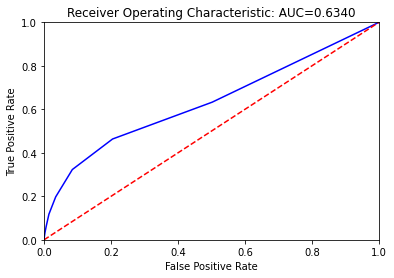

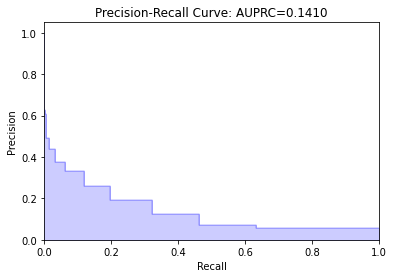

In [21]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6163240026837978
AUPRC: 0.12750691777119005
Sensitivity: 0.4102363742918539
Specificity: 0.8225158714890343
Score thresold: 2
2.5 97.5


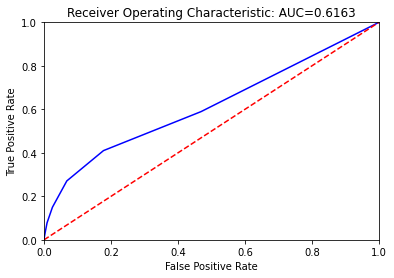

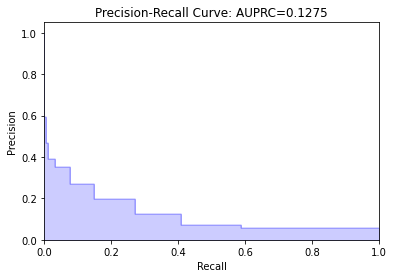

In [22]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6857031547307967
AUPRC: 0.10538899284577936
Sensitivity: 0.680601680015628
Specificity: 0.6155252020007695
Score thresold: 5
2.5 97.5


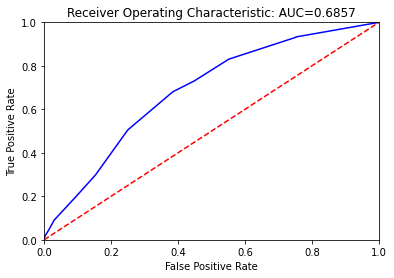

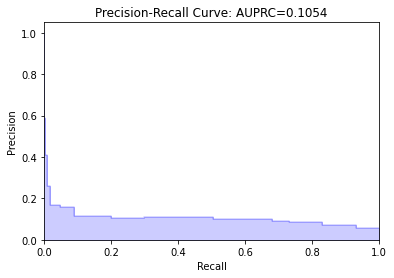

In [23]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6133614083504401
AUPRC: 0.10308247769425001
Sensitivity: 0.4301621410431725
Specificity: 0.769839361292805
Score thresold: 2
2.5 97.5


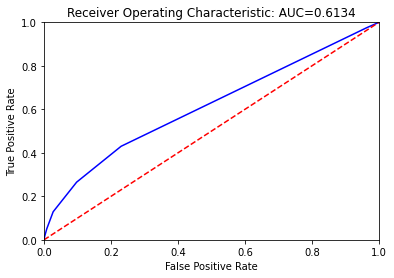

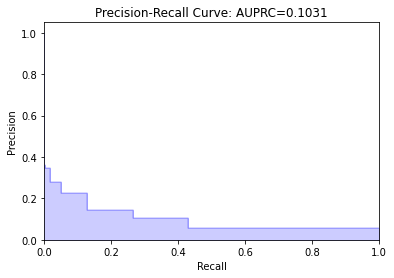

In [24]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.7071710449347095
AUPRC: 0.14136038195756145
Sensitivity: 0.5895682750537214
Specificity: 0.7306656406310119
Score thresold: 6
2.5 97.5


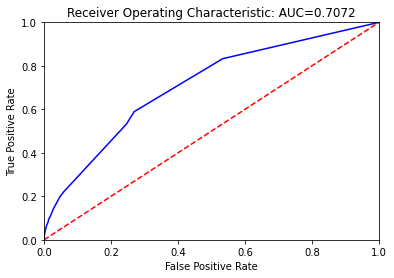

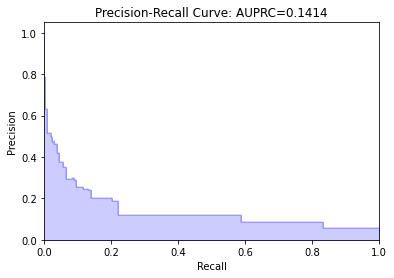

In [25]:
get_score_performance("score_CART", random_seed=random_seed)

In [26]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *

In [27]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None, 1024)        0           ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 dense_3 (Dense)                (None, 256)          262400      ['tf.math.reduce_su

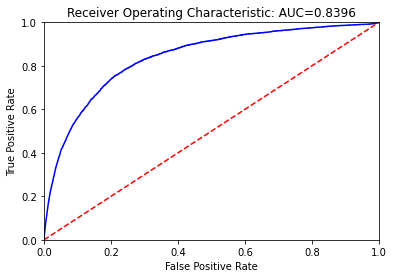

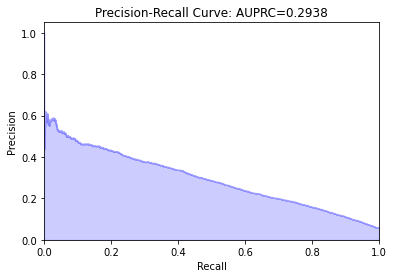

In [28]:
# To train from scratch, set load_model to None
load_model = None#"embedding_critical_"+version 
save_model = "embedding_critical_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [29]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task2.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.064,0.863 (0.859-0.868),0.32 (0.308-0.335),0.783 (0.774-0.802),0.786 (0.765-0.792),2.934
1,RF,0.073,0.874 (0.871-0.88),0.377 (0.367-0.389),0.801 (0.791-0.81),0.792 (0.791-0.796),51.861
2,GB,0.066,0.88 (0.876-0.884),0.385 (0.371-0.403),0.799 (0.786-0.817),0.799 (0.779-0.815),60.553
3,MLP,0.052,0.88 (0.877-0.885),0.375 (0.365-0.389),0.819 (0.801-0.827),0.787 (0.784-0.808),170.978
4,ESI,-2.000,0.804 (0.801-0.809),0.194 (0.187-0.205),0.87 (0.863-0.875),0.64 (0.637-0.643),0.000
5,AutoScore,66.000,0.846 (0.842-0.851),0.278 (0.267-0.293),0.804 (0.784-0.81),0.728 (0.726-0.747),0.000
6,score_NEWS,2.000,0.634 (0.627-0.64),0.141 (0.132-0.144),0.464 (0.453-0.472),0.795 (0.793-0.798),0.000
7,score_NEWS2,2.000,0.616 (0.608-0.623),0.128 (0.122-0.131),0.41 (0.399-0.586),0.823 (0.531-0.824),0.000
8,score_REMS,5.000,0.686 (0.679-0.691),0.105 (0.102-0.111),0.681 (0.668-0.687),0.616 (0.613-0.619),0.000
9,score_MEWS,2.000,0.613 (0.606-0.618),0.103 (0.1-0.108),0.43 (0.417-0.439),0.77 (0.768-0.772),0.000


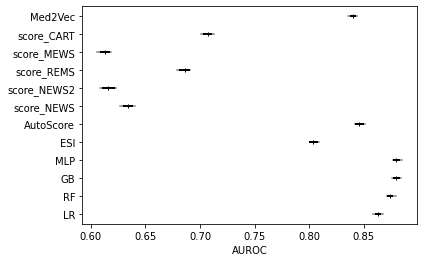

In [30]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_critical.eps', my_path = output_path) 

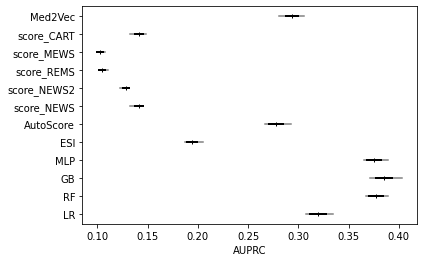

In [31]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

In [32]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
15,triage_sbp,0.100679
0,age,0.099376
12,triage_heartrate,0.093958
18,triage_acuity,0.090292
16,triage_dbp,0.084479
11,triage_temperature,0.076043
13,triage_resprate,0.056542
14,triage_o2sat,0.050261
17,triage_pain,0.041069
4,n_ed_365d,0.018774
